In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cPickle as cp
import sys
sys.path.append("../../utils")
from misc_utils import expected_loss
import os
from copy import deepcopy
from plotting_performance_vs_metric import get_closeness, get_log_closeness, get_spectrum
from plotting_performance_vs_metric import get_measurement_metric, get_performance_metric, average_results_array
from plotting_performance_vs_metric import get_nystrom_memory, get_rff_memory, get_cir_rff_memory
import math

### plot performance v.s. approximation error

In [2]:
# def get_measurement_metric(folder_name, file_name, metric_name):
# #     print folder_name
#     if os.path.isfile(folder_name + "/" + file_name):
#         with open(folder_name + "/" + file_name, "rb") as f:
#             metrics = cp.load(f)
#         metric = metrics[metric_name]
#     else:
#         print folder_name, file_name, " is not found."
#         metric = None
#     return metric

In [3]:
EPS = 1e-20

In [9]:
def get_results_for_one_precision(n_rff_feat, general_folder_measurement, 
                                  general_folder_performance, general_folder_delta,
                                  folder_pattern, seeds=[1,], min_best=True):
    f_norm_list_rff = []
    l2_loss_list_rff = []
    delta_list_rff = []
    
    for seed in seeds:
        f_norm_list = []
        l2_loss_list = []
        delta_list = []
        for n_feat in n_rff_feat:
            subfolder_name = deepcopy(folder_pattern)
            if "n_fp_feat_unk" in subfolder_name:
                subfolder_name = subfolder_name.replace("n_fp_feat_unk", "n_fp_feat_" + str(n_feat) )
            else:
                subfolder_name = subfolder_name.replace("n_feat_unk", "n_feat_" + str(n_feat) )
            subfolder_name = subfolder_name.replace("seed_unk", "seed_" + str(seed) )
            folder_name = general_folder_performance + "/" + subfolder_name
            file_name = "eval_metric.txt"
            l2_loss = get_performance_metric(folder_name, file_name, min_best=min_best)
            l2_loss_list.append(l2_loss)
            
            folder_name = general_folder_delta + "/" + subfolder_name
            if not os.path.exists(folder_name):
                folder_name = folder_name.replace("_opt_sgd_lr_10_", "_")
            file_name = "metric_sample_eval_py2.txt"
            if not os.path.isfile(folder_name + "/" + file_name):
                file_name = "metric_sample_eval.txt"
            metric_name = "Delta"
            delta = get_measurement_metric(folder_name, file_name, metric_name)
            delta_list.append(delta)
            
            file_name = "metric_sample_eval_py2.txt"
            if not os.path.isfile(folder_name + "/" + file_name):
                file_name = "metric_sample_eval.txt"
            metric_name = "F_norm_error"
            f_norm_error = get_measurement_metric(folder_name, file_name, metric_name)
            f_norm_list.append(f_norm_error)
            
        
#         print(l2_loss_list)
        
        f_norm_list_rff.append(np.array(deepcopy(f_norm_list) ) )
        l2_loss_list_rff.append(np.array(deepcopy(l2_loss_list) ) )
        delta_list_rff.append(np.array(deepcopy(delta_list) ) )
        
    f_norm_list_rff = average_results_array(f_norm_list_rff)
    l2_loss_list_rff = average_results_array(l2_loss_list_rff)
    delta_list_rff = average_results_array(delta_list_rff)
#     memory_list_rff = np.array( [rff_mem_func(n_feat) for n_feat in n_rff_feat] )
    return f_norm_list_rff, l2_loss_list_rff, delta_list_rff#, memory_list_rff

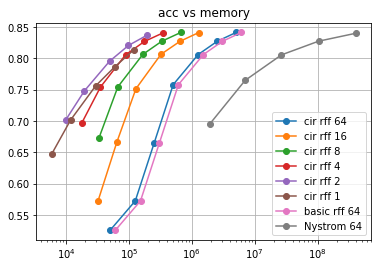

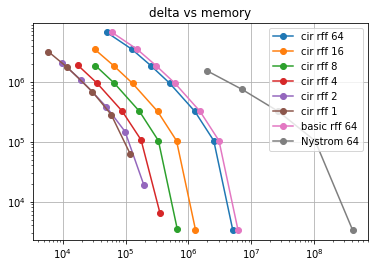

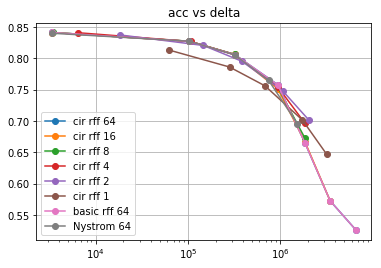

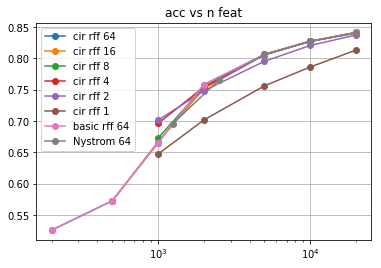

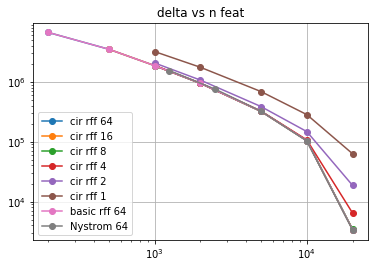

In [16]:
# n_rff_feat_dict = {64: [200, 500, 1000, 2000, 5000, 10000, 20000, 50000],
#            16: [500, 1000, 2000, 5000, 10000, 20000, 50000, ],
#            8: [1000, 2000, 5000, 10000, 20000, 50000],
#            4: [1000, 2000, 5000, 10000, 20000, 50000],
#            2: [1000, 2000, 5000, 10000, 20000, 50000],
#            1: [1000, 2000, 5000, 10000, 20000, 50000], }
n_rff_feat_dict = {64: [200, 500, 1000, 2000, 5000, 10000, 20000, ],
           16: [500, 1000, 2000, 5000, 10000, 20000 , ],
           8: [1000, 2000, 5000, 10000, 20000, ],
           4: [1000, 2000, 5000, 10000, 20000, ],
           2: [1000, 2000, 5000, 10000, 20000, ],
           1: [1000, 2000, 5000, 10000, 20000, ], }

m = 250
r = 54
# get results from cir rff runs
f_norm_dict_cir_rff = {}
l2_loss_list_cir_rff = {}
delta_list_cir_rff = {}
memory_list_cir_rff = {}
for nbit in [64, 16, 8, 4, 2, 1]:
    rff_mem_func = lambda n : get_cir_rff_memory(n, m, r, nbit)

    n_rff_feat = n_rff_feat_dict[nbit]
    general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
    general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
    general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification_delta"
    folder_pattern = "covtype_type_cir_rff_l2_reg_1e-05_n_feat_unk_n_bit_" + str(nbit) + "_opt_sgd_lr_10_seed_unk"
#     folder_pattern = "census_type_cir_rff_l2_reg_0.0005_n_feat_unk_n_bit_" + str(nbit) + "_seed_unk"
    f_norm_list, l2_loss_list, delta_list = \
        get_results_for_one_precision(n_rff_feat, general_folder_measurement, 
                                      general_folder_performance, general_folder_delta,
                                      folder_pattern=folder_pattern, seeds=[1,2,3,4,5], min_best=False)
    memory_list = [rff_mem_func(x) for x in n_rff_feat]
    f_norm_dict_cir_rff[nbit] = deepcopy(f_norm_list)
    l2_loss_list_cir_rff[nbit] = deepcopy(l2_loss_list)
    delta_list_cir_rff[nbit] = deepcopy(delta_list)
    memory_list_cir_rff[nbit] = deepcopy(memory_list)
    
#     print "cir ", nbit
#     print f_norm_list
#     print l2_loss_list
#     print delta_list
#     print memory_list
    
# get results from fp nystrom runs
nystrom_mem_func = lambda n : get_nystrom_memory(n, m, r)
n_nystrom_feat = [1250, 2500, 5000, 10000, 20000]
general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/closeness/classification_real_setting"
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/closeness/classification_real_setting"
general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/symmetric_delta/classification_real_setting"
folder_pattern = "covtype_with_metric_type_rff_l2_reg_1e-05_n_fp_feat_unk_opt_sgd_lr_10_seed_unk"
f_norm_list_nystrom, l2_loss_list_nystrom, delta_list_nystrom = \
    get_results_for_one_precision(n_nystrom_feat, general_folder_measurement, 
                                  general_folder_performance, general_folder_delta,
                                  folder_pattern=folder_pattern, seeds=[1,2,3,], min_best=False)
memory_list_nystrom = [nystrom_mem_func(x) for x in n_nystrom_feat]
    
# get results from basic rff runs
rff_mem_func = lambda n : get_rff_memory(n, m, r)
n_rff_feat = n_rff_feat_dict[64]
general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification_delta"
# folder_pattern = "census_type_rff_l2_reg_0.0005_n_feat_unk_n_bit_" + str(64) + "_seed_unk"
folder_pattern = "covtype_type_cir_rff_l2_reg_1e-05_n_feat_unk_n_bit_" + str(64) + "_opt_sgd_lr_10_seed_unk"
f_norm_list_rff, l2_loss_list_rff, delta_list_rff = \
    get_results_for_one_precision(n_rff_feat, general_folder_measurement, 
                                  general_folder_performance, general_folder_delta,
                                  folder_pattern=folder_pattern, seeds=[1,2,3,4,5], min_best=False)
memory_list_rff = [rff_mem_func(x) for x in n_rff_feat]
# print "basic", nbit
# print f_norm_list_rff
# print l2_loss_list_rff
# print delta_list_rff
# print memory_list_rff

plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(memory_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(memory_list_rff, l2_loss_list_rff, "-o", label="basic rff " + str(64) )    
plt.plot(memory_list_nystrom, l2_loss_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
# plt.yscale("log")
plt.xscale("log")
plt.title("acc vs memory")
plt.legend()
# plt.ylim([None, 2e8])
plt.show()

plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(memory_list_cir_rff[nbit], delta_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(memory_list_rff, delta_list_rff, "-o", label="basic rff " + str(64) )    
plt.plot(memory_list_nystrom, delta_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.title("delta vs memory")
plt.legend()
# plt.ylim([None, 2e8])
plt.show()

plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(delta_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(delta_list_rff, l2_loss_list_rff, "-o", label="basic rff " + str(64) )  
plt.plot(delta_list_nystrom, l2_loss_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
# plt.yscale("log")
plt.xscale("log")
plt.title("acc vs delta")
plt.legend()
# plt.ylim([None, 2e8])
plt.show()


plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(n_rff_feat_dict[nbit], l2_loss_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(n_rff_feat_dict[64], l2_loss_list_rff, "-o", label="basic rff " + str(64) )    
plt.plot(n_nystrom_feat, l2_loss_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
# plt.yscale("log")
plt.xscale("log")
plt.title("acc vs n feat")
plt.legend()
# plt.ylim([None, 2e8])
plt.show()

plt.figure()
for nbit in [64, 16, 8, 4, 2, 1]:
    plt.plot(n_rff_feat_dict[nbit], delta_list_cir_rff[nbit], "-o", label="cir rff " + str(nbit) )
plt.plot(n_rff_feat_dict[64], delta_list_rff, "-o", label="basic rff " + str(64) )    
plt.plot(n_nystrom_feat, delta_list_nystrom, "-o", label="Nystrom " + str(64) )    
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.title("delta vs n feat")
plt.legend()
# plt.ylim([None, 2e8])
plt.show()